<a href="https://colab.research.google.com/github/osbornep8/portfolioprojects/blob/main/MedicalImg_Histogram_Analyses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medical Image Histogram Analysis: Applications in Radiology



## Introduction

Histogram analysis is a fundamental technique in image processing that has important applications in medical imaging. While color histograms are commonly used for natural images, medical images often require specialized approaches due to their grayscale nature and the specific meaning of intensity values in modalities like CT and MRI.

This notebook explores how histogram analysis can be applied to medical images for enhancement, quantification, and feature extraction and even image retrieval.

## Table of Content:

1. Setup and Image Loading
2. Basic Histogram Analysis
3. Image Enhancement
4. Region of Interest (ROI) Analysis
5. Texture Analysis with GLCM
6. 3D Visualization and Analysis
7. Color Mapping for Visualization
8. Clinical Applications
9. Conclusion
10. Bonus Content

## 1. Setup and Image Loading

First, let's import the necessary libraries and load our medical images.


In [22]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.feature import graycomatrix, graycoprops
from skimage import exposure
import os
from scipy import ndimage as ndi

Now, let's load the sample medical images. In a real notebook, you'd load your own images. For this example, we'll simulate loading the chest CT and brain MRI images you provided.


In [23]:
# Load the images
def load_medical_image(image_path):
    """Load a medical image from file"""
    if os.path.exists(image_path):
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        return image
    else:
        print(f"Image file not found: {image_path}")
        # Create a sample image for demonstration
        return np.random.randint(0, 256, (512, 512), dtype=np.uint8)

# Load chest CT and brain MRI (Replace these paths with your actual image paths, links will be provided)
chest_ct = load_medical_image("/content/CT_adenocarcinoma_chest.png")
brain_mri = load_medical_image("/content/MRI_brain_tumor.jpg")

# For demo purposes, if the images couldn't be loaded, create sample arrays
# with characteristics similar to the described images
if chest_ct is None:
    # Create a synthetic lung CT image with bright regions in the center
    chest_ct = np.ones((512, 512), dtype=np.uint8) * 40  # Dark background
    chest_ct[100:400, 100:400] = 120  # Chest cavity
    chest_ct[150:350, 150:350] = 70   # Lungs
    # Add a bright nodule in the right lung
    chest_ct[200:250, 200:250] = 180  # Bright nodule (simulated adenocarcinoma)
    chest_ct = cv2.GaussianBlur(chest_ct, (15, 15), 0)  # Smooth

if brain_mri is None:
    # Create a synthetic brain MRI with a bright tumor
    brain_mri = np.ones((512, 512), dtype=np.uint8) * 50  # Dark background
    # Create brain shape
    center = (256, 256)
    brain_radius = 200
    y, x = np.ogrid[:512, :512]
    brain_mask = ((x - center[0])**2 + (y - center[1])**2 <= brain_radius**2)
    brain_mri[brain_mask] = 100  # Brain tissue
    # Add bright tumor
    tumor_center = (150, 256)
    tumor_radius = 50
    tumor_mask = ((x - tumor_center[0])**2 + (y - tumor_center[1])**2 <= tumor_radius**2)
    brain_mri[tumor_mask] = 220  # Bright tumor
    brain_mri = cv2.GaussianBlur(brain_mri, (11, 11), 0)  # Smooth


Let's visualize our medical images:

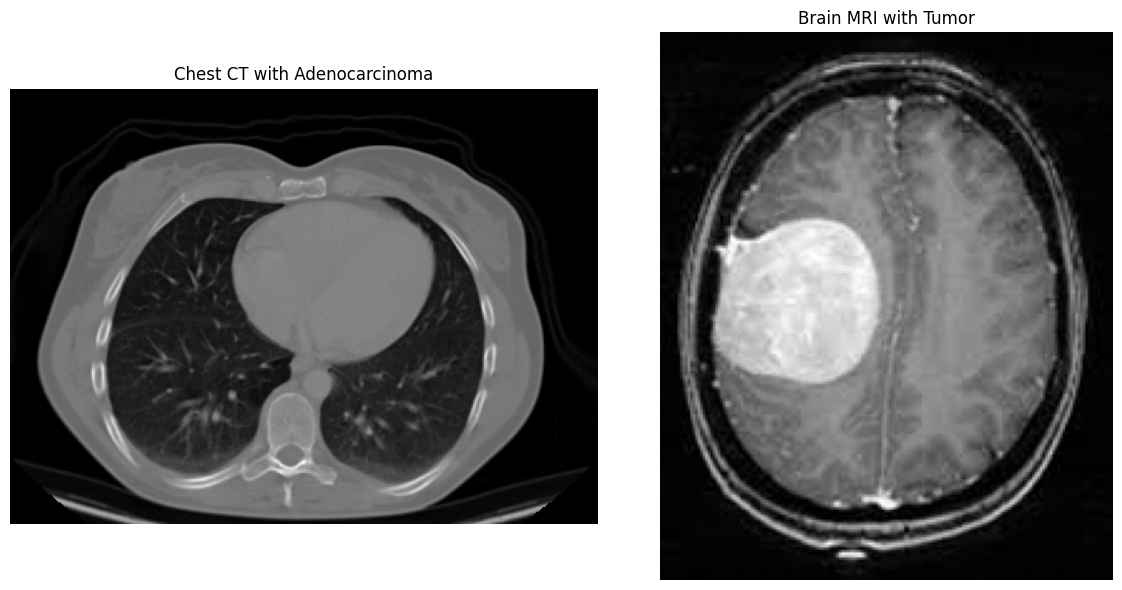

In [26]:

# Display the medical images
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(chest_ct, cmap='gray')
axes[0].set_title('Chest CT with Adenocarcinoma')
axes[0].axis('off')

axes[1].imshow(brain_mri, cmap='gray')
axes[1].set_title('Brain MRI with Tumor')
axes[1].axis('off')

plt.tight_layout()
plt.show()

## 2. Basic Histogram Analysis

Let's start by examining the basic intensity histograms of these medical images.


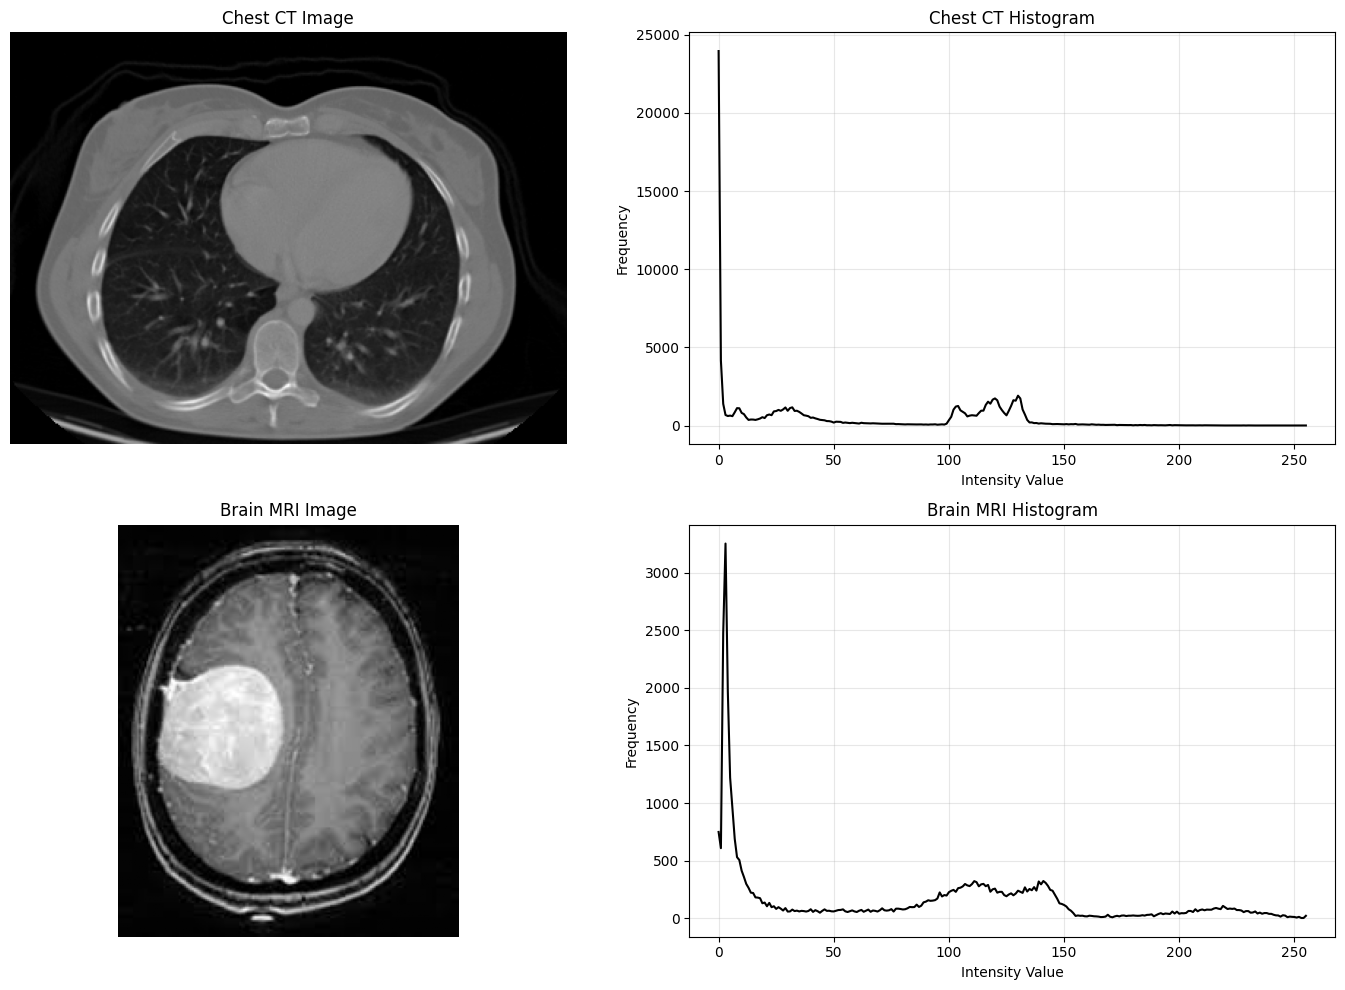

In [27]:
# Plot histograms of the imgs
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Chest CT
axes[0, 0].imshow(chest_ct, cmap='gray')
axes[0, 0].set_title('Chest CT Image')
axes[0, 0].axis('off')

hist_ct = cv2.calcHist([chest_ct], [0], None, [256], [0, 256])
axes[0, 1].plot(hist_ct, color='black')
axes[0, 1].set_title('Chest CT Histogram')
axes[0, 1].set_xlabel('Intensity Value')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(alpha=0.3)

# Brain MRI
axes[1, 0].imshow(brain_mri, cmap='gray')
axes[1, 0].set_title('Brain MRI Image')
axes[1, 0].axis('off')

hist_mri = cv2.calcHist([brain_mri], [0], None, [256], [0, 256])
axes[1, 1].plot(hist_mri, color='black')
axes[1, 1].set_title('Brain MRI Histogram')
axes[1, 1].set_xlabel('Intensity Value')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Image Enhancement with Histogram Techniques

One common application of histogram analysis in medical imaging is to enhance the visibility of structures through techniques like histogram equalization and windowing.



### 3.1 Histogram Equalization

Histogram equalization improves contrast by redistributing intensity values:


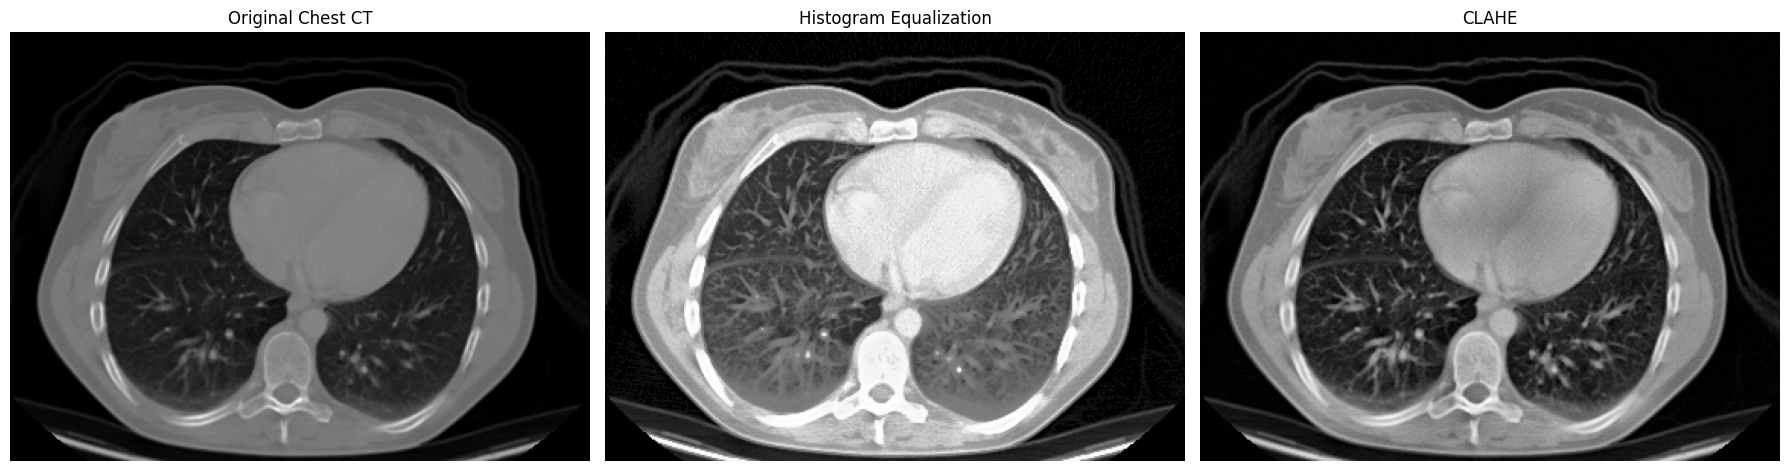

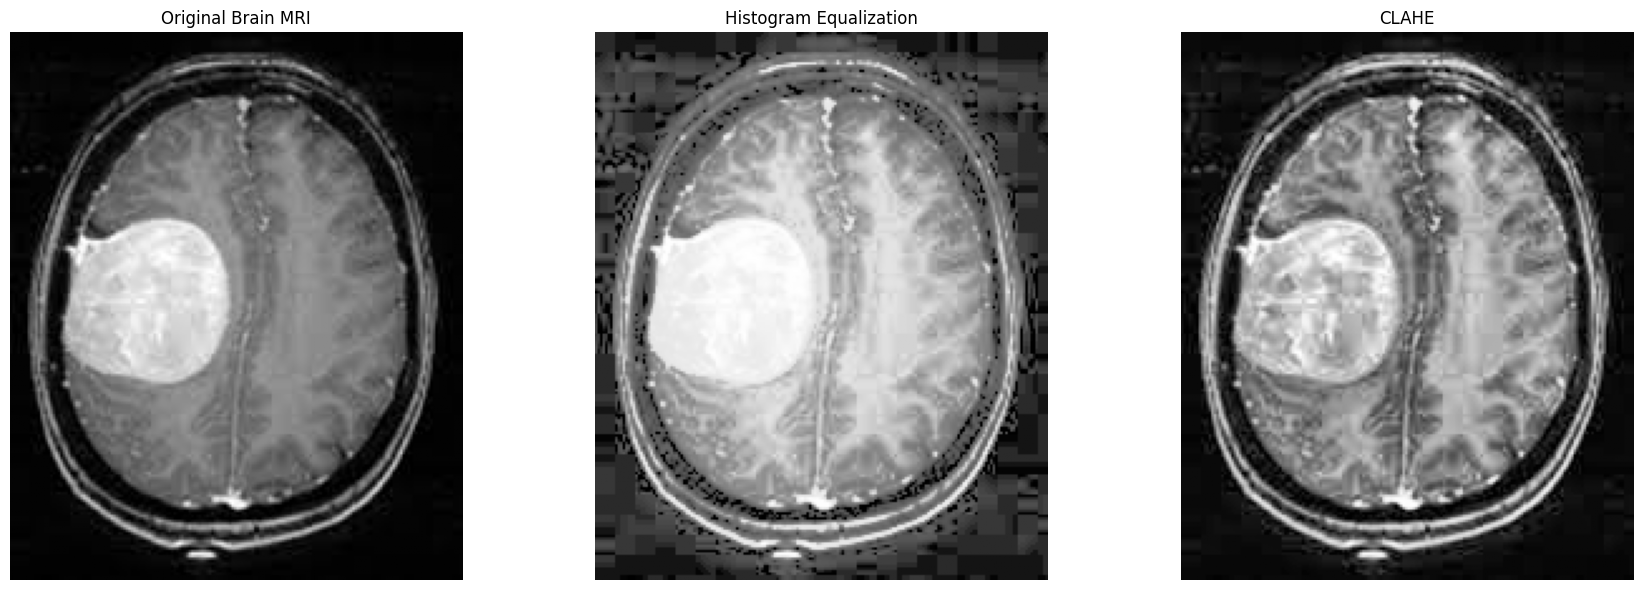

In [28]:
# Apply histogram equalization
ct_equalized = cv2.equalizeHist(chest_ct)
mri_equalized = cv2.equalizeHist(brain_mri)

# Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
ct_clahe = clahe.apply(chest_ct)
mri_clahe = clahe.apply(brain_mri)

# Display results for Chest CT
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(chest_ct, cmap='gray')
axes[0].set_title('Original Chest CT')
axes[0].axis('off')

axes[1].imshow(ct_equalized, cmap='gray')
axes[1].set_title('Histogram Equalization')
axes[1].axis('off')

axes[2].imshow(ct_clahe, cmap='gray')
axes[2].set_title('CLAHE')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Display results for Brain MRI
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(brain_mri, cmap='gray')
axes[0].set_title('Original Brain MRI')
axes[0].axis('off')

axes[1].imshow(mri_equalized, cmap='gray')
axes[1].set_title('Histogram Equalization')
axes[1].axis('off')

axes[2].imshow(mri_clahe, cmap='gray')
axes[2].set_title('CLAHE')
axes[2].axis('off')

plt.tight_layout()
plt.show()


### 3.2 Windowing (Window/Level Adjustment)

In medical imaging, windowing is a technique used to focus on specific tissue types by adjusting the contrast range:


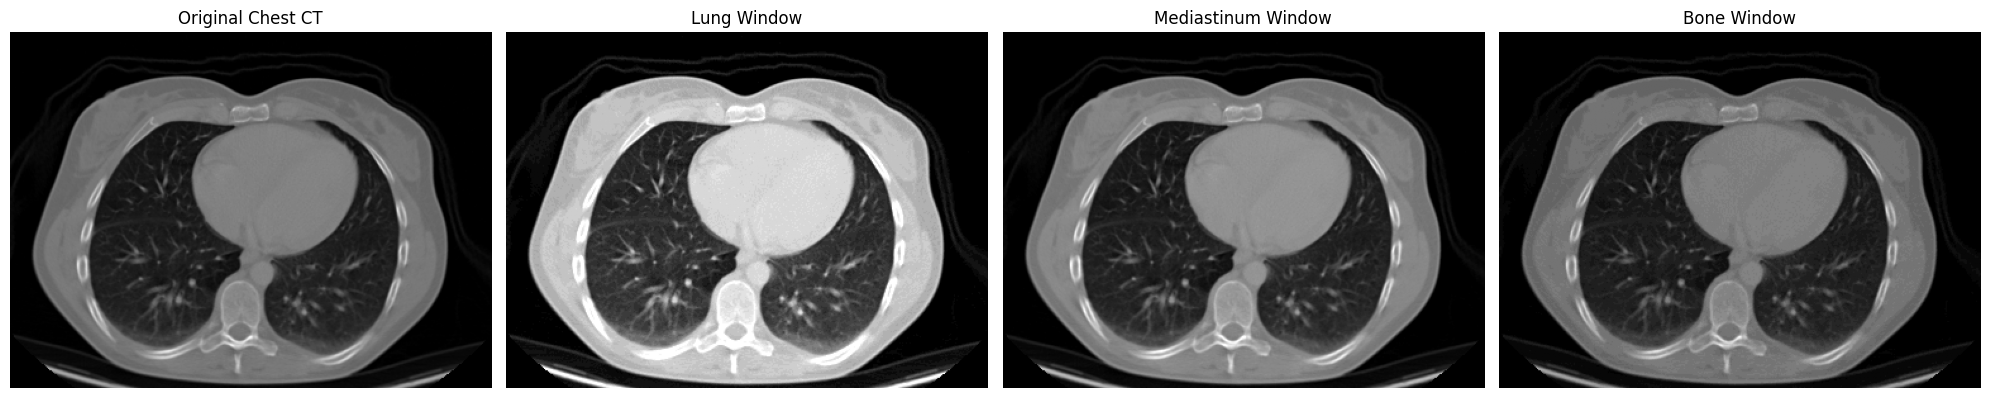

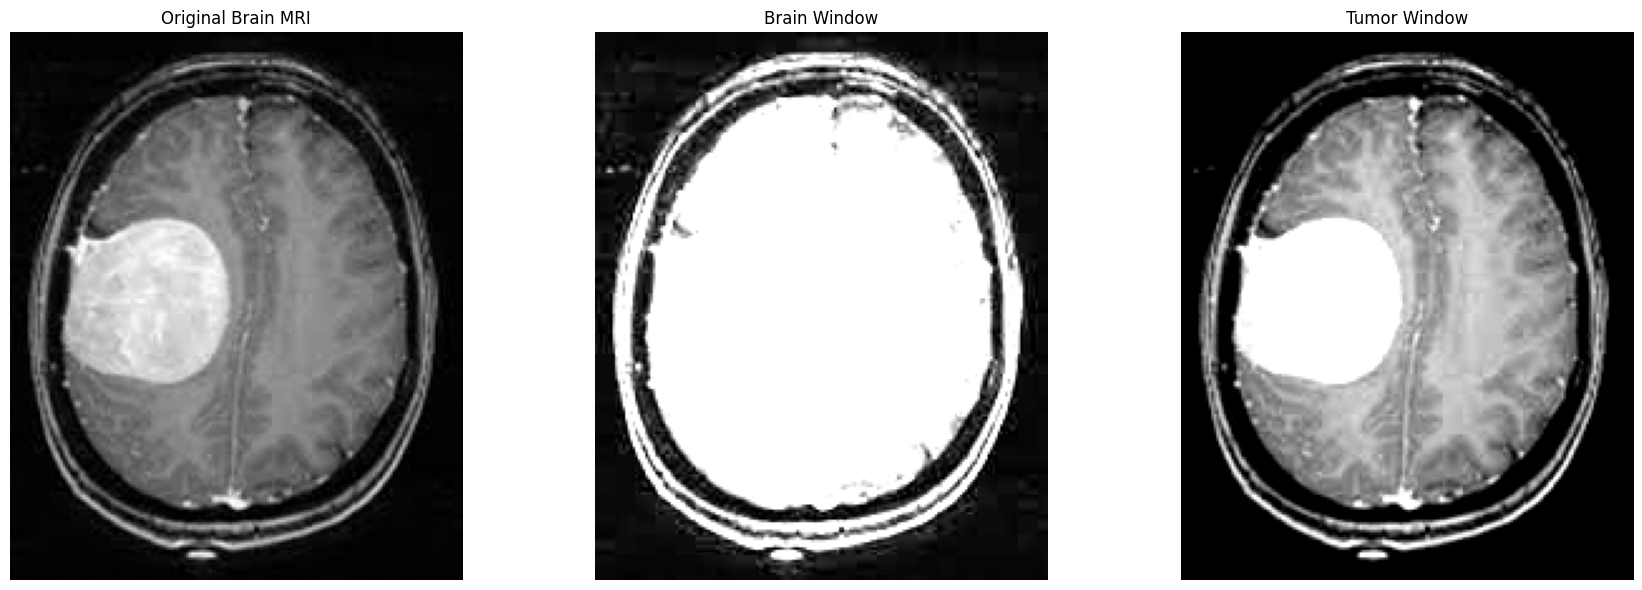

In [29]:
def apply_window_level(image, window, level):
    """Apply windowing to a medical image

    Args:
        image: Input image
        window: Width of the window
        level: Center of the window

    Returns:
        Windowed image
    """
    min_val = level - window/2
    max_val = level + window/2

    # Clip values to the window range
    windowed = np.clip(image, min_val, max_val)

    # Normalize to 0-255 range
    windowed = 255 * (windowed - min_val) / (max_val - min_val)
    return windowed.astype(np.uint8)

# Apply different windows to the CT scan
# For demonstration purposes - in real medical imaging, specific window values
# would be used based on modality and anatomy
ct_lung_window = apply_window_level(chest_ct, 1500, -600)  # Lung window
ct_mediastinum_window = apply_window_level(chest_ct, 350, 50)  # Mediastinum window
ct_bone_window = apply_window_level(chest_ct, 2000, 400)  # Bone window

# Display the different CT windows
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

axes[0].imshow(chest_ct, cmap='gray')
axes[0].set_title('Original Chest CT')
axes[0].axis('off')

axes[1].imshow(ct_lung_window, cmap='gray')
axes[1].set_title('Lung Window')
axes[1].axis('off')

axes[2].imshow(ct_mediastinum_window, cmap='gray')
axes[2].set_title('Mediastinum Window')
axes[2].axis('off')

axes[3].imshow(ct_bone_window, cmap='gray')
axes[3].set_title('Bone Window')
axes[3].axis('off')

plt.tight_layout()
plt.show()

# Apply different windows to the MRI
mri_brain_window = apply_window_level(brain_mri, 80, 40)  # Brain window
mri_tumor_window = apply_window_level(brain_mri, 150, 100)  # Tumor window

# Display the different MRI windows
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(brain_mri, cmap='gray')
axes[0].set_title('Original Brain MRI')
axes[0].axis('off')

axes[1].imshow(mri_brain_window, cmap='gray')
axes[1].set_title('Brain Window')
axes[1].axis('off')

axes[2].imshow(mri_tumor_window, cmap='gray')
axes[2].set_title('Tumor Window')
axes[2].axis('off')

plt.tight_layout()
plt.show()

## 4. Region of Interest (ROI) Analysis

Instead of analyzing the entire image, we can focus on specific regions of interest, which is particularly valuable in medical images where pathology might be localized.


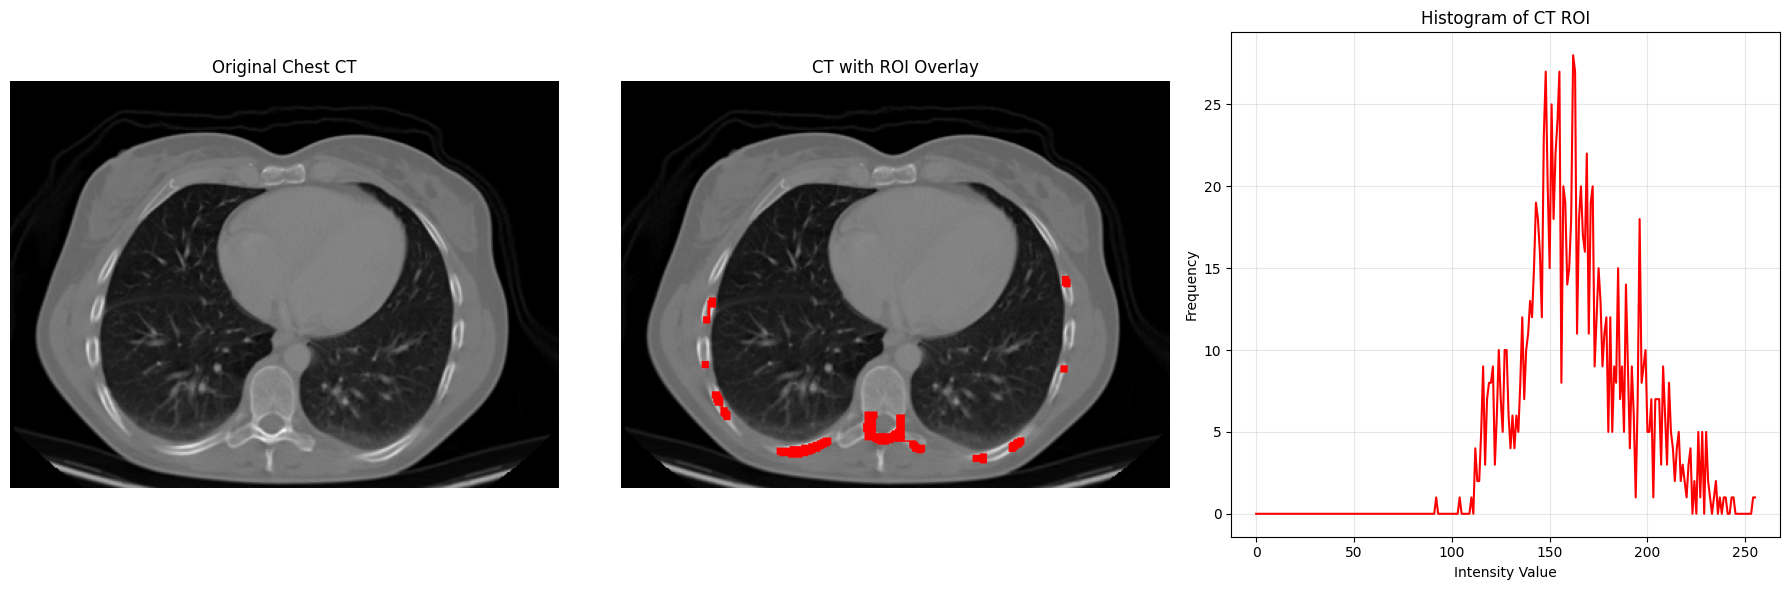

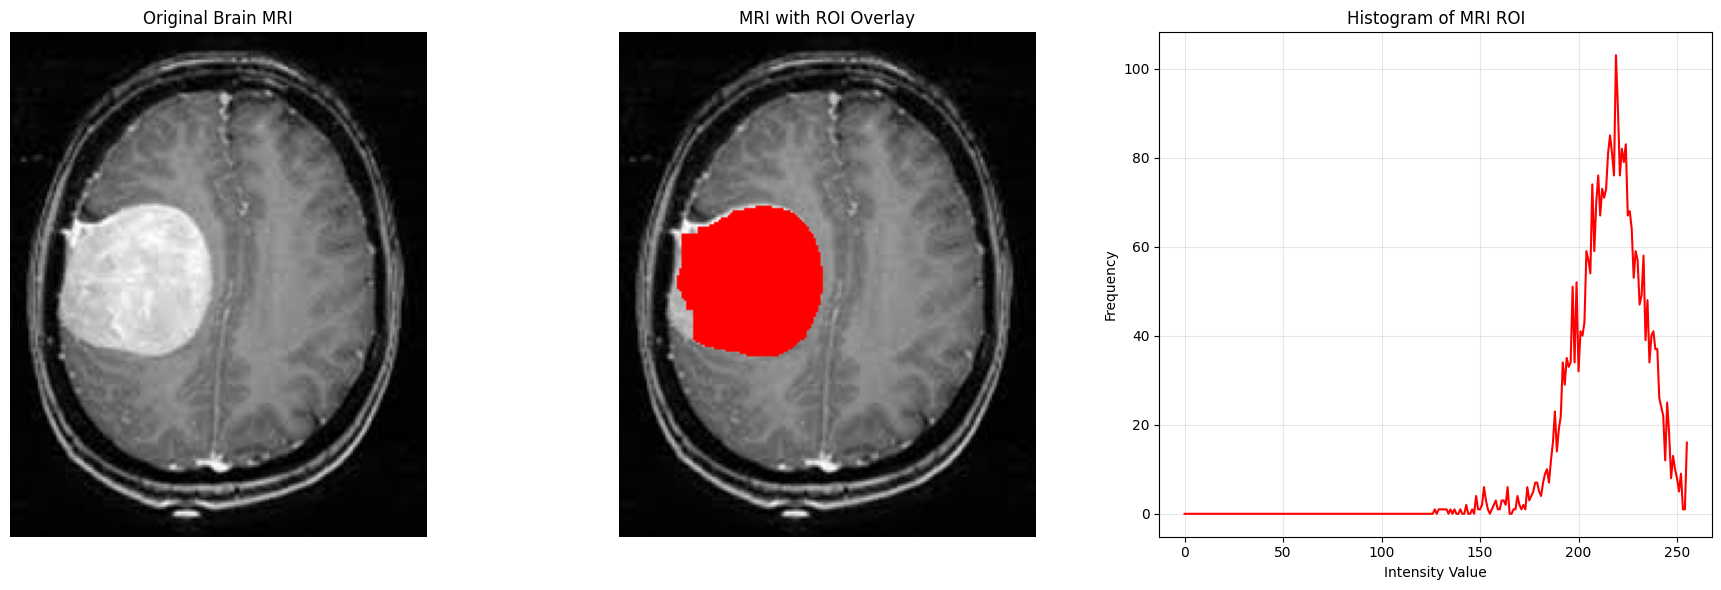

In [30]:
# Create a simple thresholding-based segmentation for demonstration
# Note: In real applications, more sophisticated segmentation would be used
def create_region_mask(image, threshold_low, threshold_high):
    """Create a binary mask based on thresholding"""
    mask = np.zeros_like(image)
    mask[(image >= threshold_low) & (image <= threshold_high)] = 1
    return mask

# Create masks for regions of interest
# In the CT, find bright regions that might correspond to the tumor
ct_roi_mask = create_region_mask(chest_ct, 140, 255)
# In the MRI, find bright regions that might correspond to the tumor
mri_roi_mask = create_region_mask(brain_mri, 180, 255)

# Clean up the masks using morphological operations
ct_roi_mask = cv2.morphologyEx(ct_roi_mask, cv2.MORPH_OPEN, np.ones((5, 5), np.uint8))
ct_roi_mask = cv2.morphologyEx(ct_roi_mask, cv2.MORPH_CLOSE, np.ones((10, 10), np.uint8))

mri_roi_mask = cv2.morphologyEx(mri_roi_mask, cv2.MORPH_OPEN, np.ones((5, 5), np.uint8))
mri_roi_mask = cv2.morphologyEx(mri_roi_mask, cv2.MORPH_CLOSE, np.ones((10, 10), np.uint8))

# Calculate histograms for the ROIs
ct_roi_hist = cv2.calcHist([chest_ct], [0], ct_roi_mask.astype(np.uint8), [256], [0, 256])
mri_roi_hist = cv2.calcHist([brain_mri], [0], mri_roi_mask.astype(np.uint8), [256], [0, 256])

# Display the CT ROI and its histogram
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(chest_ct, cmap='gray')
axes[0].set_title('Original Chest CT')
axes[0].axis('off')

# Overlay the ROI mask on the original image
ct_with_roi = chest_ct.copy()
ct_with_roi = cv2.cvtColor(ct_with_roi, cv2.COLOR_GRAY2RGB)
ct_with_roi[ct_roi_mask == 1] = [255, 0, 0]  # Red overlay
axes[1].imshow(ct_with_roi)
axes[1].set_title('CT with ROI Overlay')
axes[1].axis('off')

axes[2].plot(ct_roi_hist, color='red')
axes[2].set_title('Histogram of CT ROI')
axes[2].set_xlabel('Intensity Value')
axes[2].set_ylabel('Frequency')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Display the MRI ROI and its histogram
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(brain_mri, cmap='gray')
axes[0].set_title('Original Brain MRI')
axes[0].axis('off')

# Overlay the ROI mask on the original image
mri_with_roi = brain_mri.copy()
mri_with_roi = cv2.cvtColor(mri_with_roi, cv2.COLOR_GRAY2RGB)
mri_with_roi[mri_roi_mask == 1] = [255, 0, 0]  # Red overlay
axes[1].imshow(mri_with_roi)
axes[1].set_title('MRI with ROI Overlay')
axes[1].axis('off')

axes[2].plot(mri_roi_hist, color='red')
axes[2].set_title('Histogram of MRI ROI')
axes[2].set_xlabel('Intensity Value')
axes[2].set_ylabel('Frequency')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()


## 5. Advanced Texture Analysis with GLCM

Gray Level Co-occurrence Matrix (GLCM) extends histogram analysis to capture spatial relationships between pixels, which is particularly useful for characterizing tissue textures.



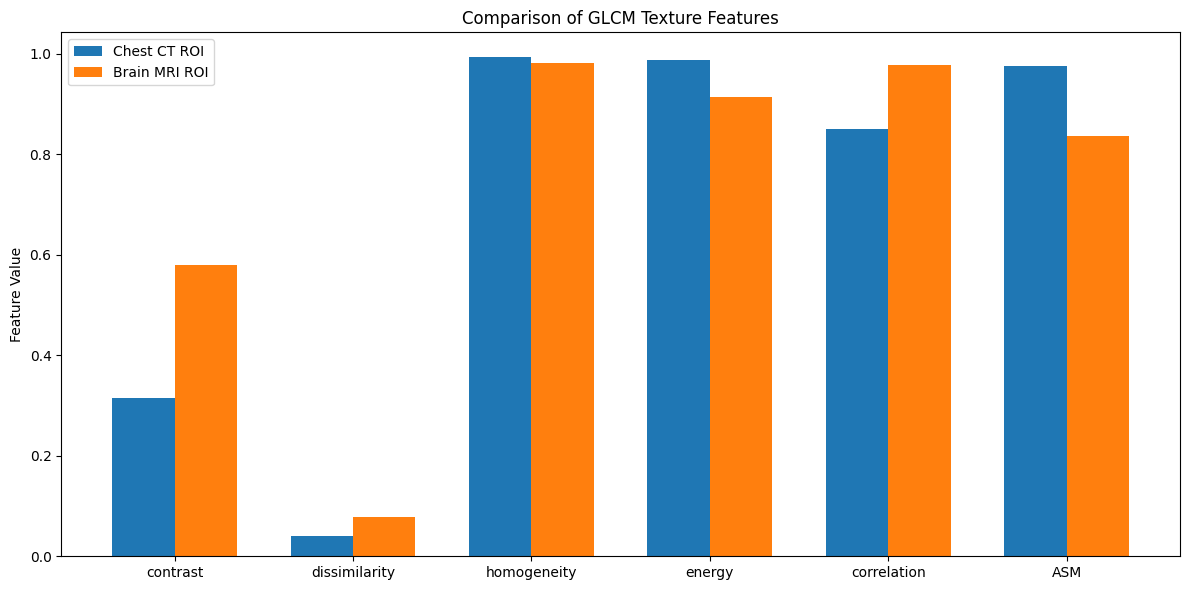

In [32]:

def extract_glcm_features(image, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=16):
    """Extract texture features using GLCM

    Args:
        image: Input grayscale image
        distances: List of pixel distances
        angles: List of pixel angles
        levels: Number of gray levels to use

    Returns:
        Dictionary of GLCM features
    """
    # Rescale image to fewer gray levels to make GLCM computation feasible
    # rescaled = np.round(image / 256 * levels).astype(np.uint8)
    rescaled = np.round(image / np.max(image) * (levels - 1)).astype(np.uint8) # Normalize between 0 and levels-1

    # Compute GLCM
    glcm = graycomatrix(rescaled, distances, angles, levels, symmetric=True, normed=True)

    # Extract GLCM properties
    features = {
        'contrast': graycoprops(glcm, 'contrast').mean(),
        'dissimilarity': graycoprops(glcm, 'dissimilarity').mean(),
        'homogeneity': graycoprops(glcm, 'homogeneity').mean(),
        'energy': graycoprops(glcm, 'energy').mean(),
        'correlation': graycoprops(glcm, 'correlation').mean(),
        'ASM': graycoprops(glcm, 'ASM').mean()
    }

    return features

# Extract GLCM features from the ROIs
ct_features = extract_glcm_features(chest_ct * ct_roi_mask)
mri_features = extract_glcm_features(brain_mri * mri_roi_mask)

# Compare texture features between the two images
feature_names = list(ct_features.keys())
ct_values = [ct_features[f] for f in feature_names]
mri_values = [mri_features[f] for f in feature_names]

# Plot the comparison
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(feature_names))
width = 0.35

ax.bar(x - width/2, ct_values, width, label='Chest CT ROI')
ax.bar(x + width/2, mri_values, width, label='Brain MRI ROI')

ax.set_xticks(x)
ax.set_xticklabels(feature_names)
ax.set_ylabel('Feature Value')
ax.set_title('Comparison of GLCM Texture Features')
ax.legend()

plt.tight_layout()
plt.show()

## 6. 3D Visualization and Analysis

Medical images are often 3D volumes. While we're working with 2D slices in this example, let's simulate how we might apply histogram analysis to 3D data.


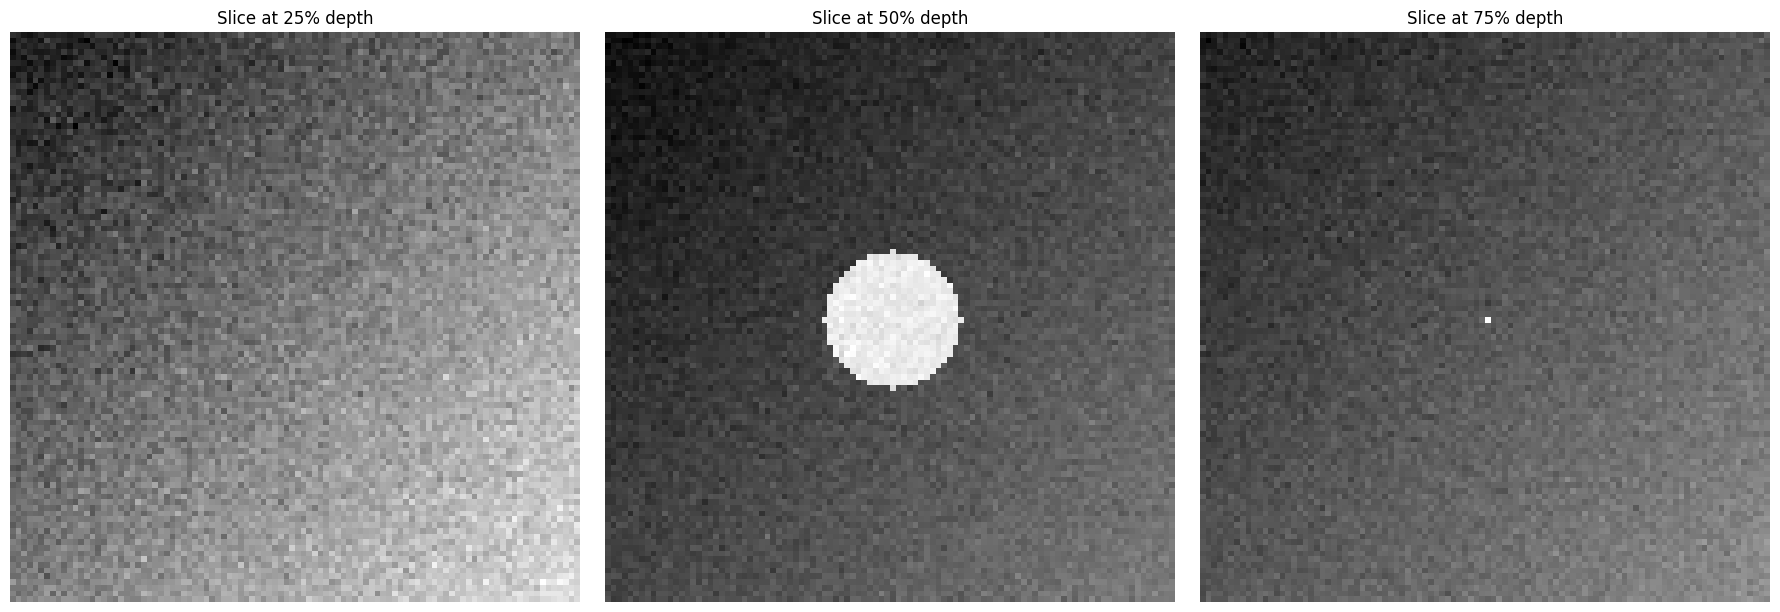

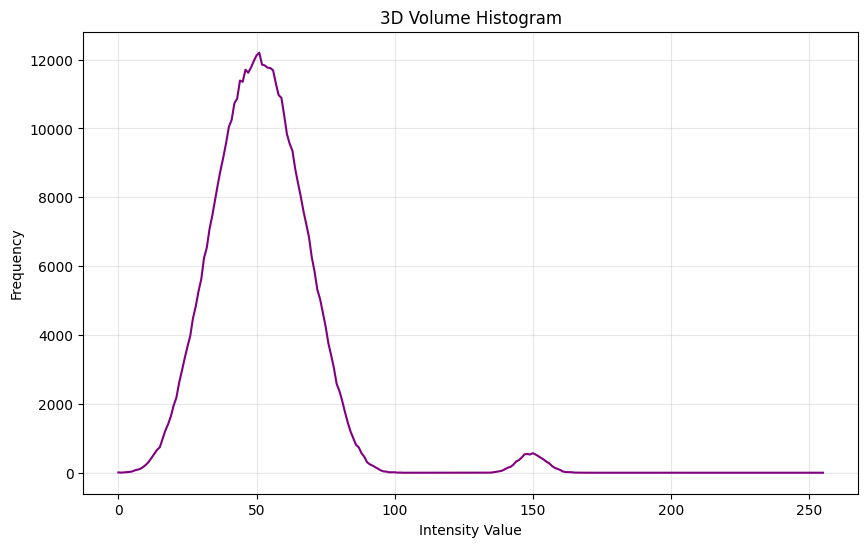

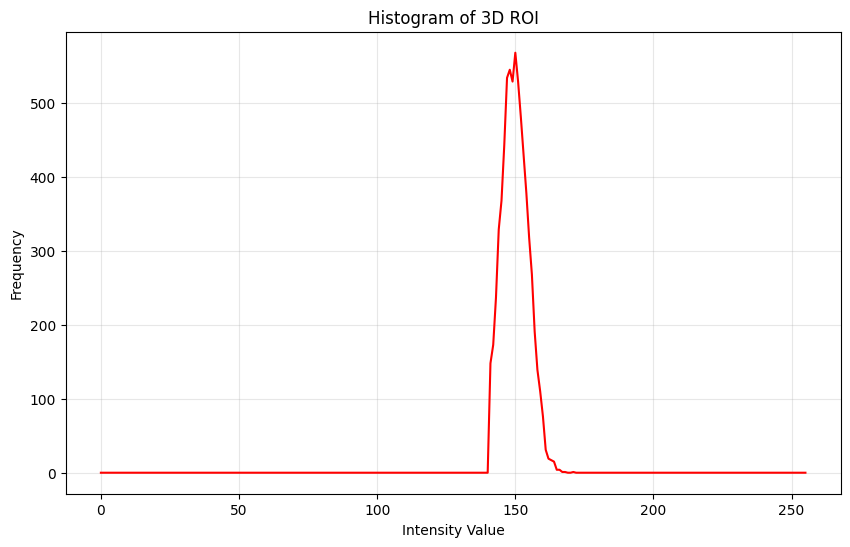

In [33]:
# Create a simple synthetic 3D volume for demonstration
def create_synthetic_volume(size=(100, 100, 100)):
    """Create a synthetic 3D volume with a spherical structure"""
    volume = np.zeros(size)

    # Create a background gradient
    z, y, x = np.ogrid[:size[0], :size[1], :size[2]]
    volume = (x + y + z) / 3 / size[0] * 50 + 10

    # Add a spherical structure
    center = (size[0]//2, size[1]//2, size[2]//2)
    radius = min(size) // 4

    sphere_mask = ((z - center[0])**2 + (y - center[1])**2 + (x - center[2])**2) <= radius**2
    volume[sphere_mask] = 150

    # Add some noise
    volume += np.random.normal(0, 5, size)

    return np.clip(volume, 0, 255).astype(np.uint8)

# Create a synthetic volume
volume = create_synthetic_volume((50, 100, 100))

# Display some slices of the volume
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(volume[volume.shape[0]//4, :, :], cmap='gray')
axes[0].set_title('Slice at 25% depth')
axes[0].axis('off')

axes[1].imshow(volume[volume.shape[0]//2, :, :], cmap='gray')
axes[1].set_title('Slice at 50% depth')
axes[1].axis('off')

axes[2].imshow(volume[3*volume.shape[0]//4, :, :], cmap='gray')
axes[2].set_title('Slice at 75% depth')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Compute and visualize the histogram of the entire volume
volume_hist = np.histogram(volume, bins=256, range=(0, 255))[0]

plt.figure(figsize=(10, 6))
plt.plot(volume_hist, color='purple')
plt.title('3D Volume Histogram')
plt.xlabel('Intensity Value')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.show()

# Create a 3D ROI by thresholding
volume_roi = (volume > 140).astype(np.uint8)

# Compute histogram of the ROI
roi_hist = np.histogram(volume[volume_roi > 0], bins=256, range=(0, 255))[0]

plt.figure(figsize=(10, 6))
plt.plot(roi_hist, color='red')
plt.title('Histogram of 3D ROI')
plt.xlabel('Intensity Value')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.show()

## 7. Color Mapping for Visualization

Although medical images are typically grayscale, applying color maps can enhance visualization:


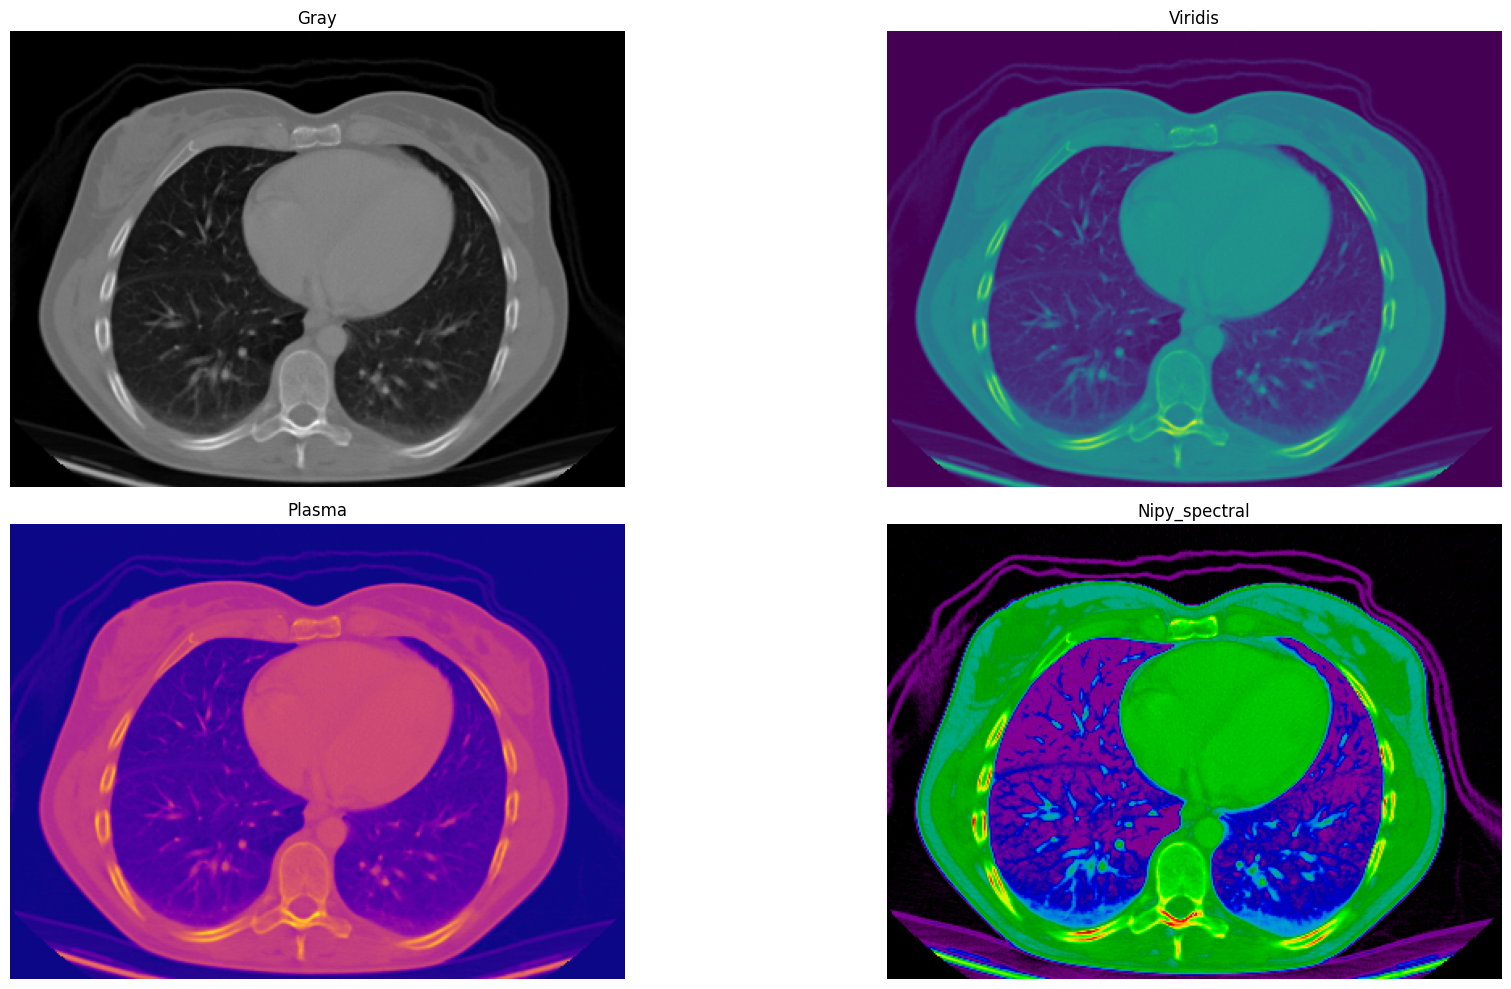

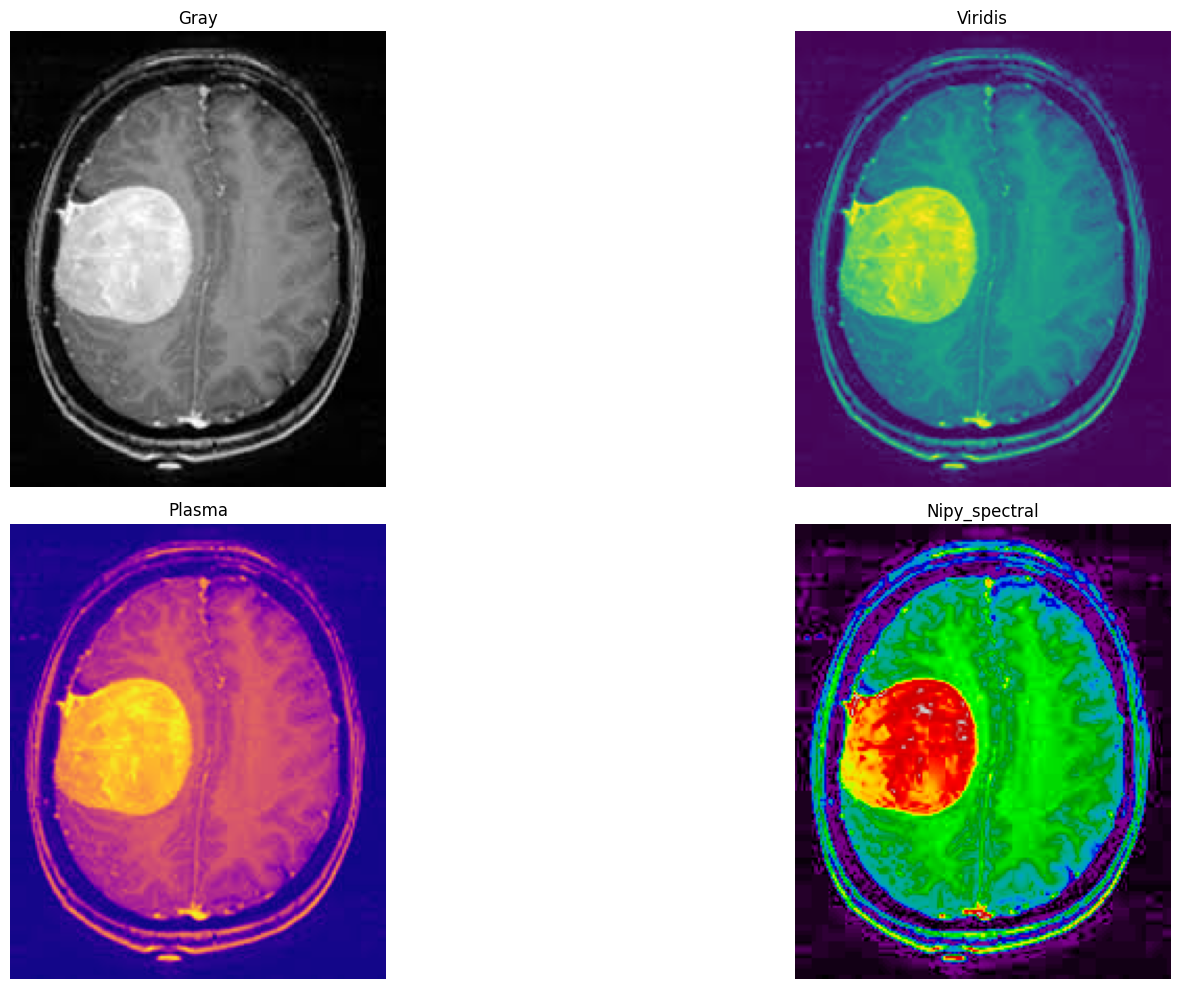

In [42]:
def apply_colormap(image, cmap_name='jet'):
    """Apply a colormap to a grayscale image

    Args:
        image: Grayscale image
        cmap_name: Name of matplotlib colormap

    Returns:
        Colorized image
    """
    cmap = plt.get_cmap(cmap_name)
    normalized = image.astype(float) / 255.0
    colored = cmap(normalized)
    # Convert to 8-bit RGB
    return (colored[:, :, :3] * 255).astype(np.uint8)

# Create a list of useful medical colormaps
colormaps = ['gray', 'viridis', 'plasma', 'nipy_spectral']

# Apply colormaps to the chest CT
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()

for i, cmap_name in enumerate(colormaps):
    colored = apply_colormap(chest_ct, cmap_name)
    axes[i].imshow(colored)
    axes[i].set_title(f'{cmap_name.capitalize()}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Apply colormaps to the brain MRI
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()

for i, cmap_name in enumerate(colormaps):
    colored = apply_colormap(brain_mri, cmap_name)
    axes[i].imshow(colored)
    axes[i].set_title(f'{cmap_name.capitalize()}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


## 8. Clinical Applications and Future Directions

Histogram analysis in medical imaging has numerous clinical applications:


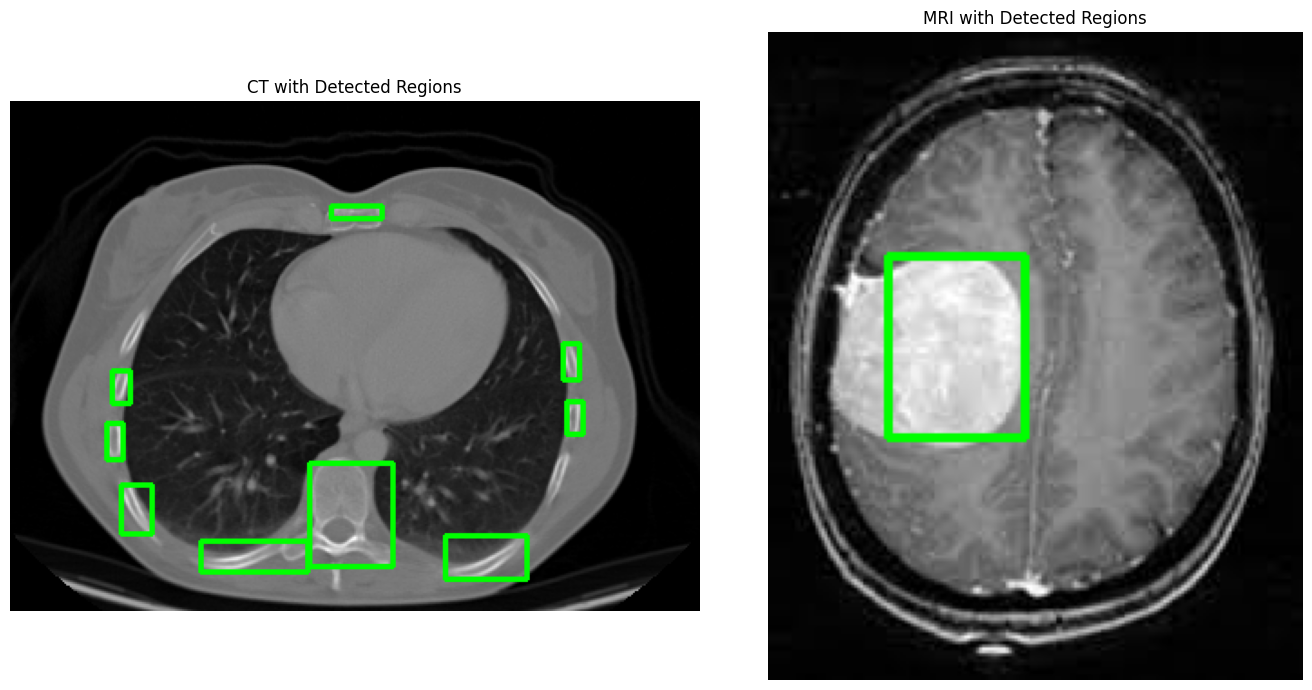

Features of detected regions in Chest CT:
Region 1:
  Area: 336.5 pixels
  Mean intensity: 129.34
  Std deviation: 38.37
  Texture features:
    contrast: 1.4351
    dissimilarity: 0.7247
    homogeneity: 0.7047
    energy: 0.2433
    correlation: 0.8854
    ASM: 0.0598

Region 2:
  Area: 281.5 pixels
  Mean intensity: 109.38
  Std deviation: 45.17
  Texture features:
    contrast: 1.5654
    dissimilarity: 0.7278
    homogeneity: 0.7111
    energy: 0.2142
    correlation: 0.9225
    ASM: 0.0461

Region 3:
  Area: 148.0 pixels
  Mean intensity: 124.15
  Std deviation: 49.84
  Texture features:
    contrast: 2.3012
    dissimilarity: 0.9699
    homogeneity: 0.6365
    energy: 0.2355
    correlation: 0.8993
    ASM: 0.0559

Region 4:
  Area: 874.0 pixels
  Mean intensity: 125.69
  Std deviation: 38.85
  Texture features:
    contrast: 0.7482
    dissimilarity: 0.4308
    homogeneity: 0.8142
    energy: 0.3663
    correlation: 0.9282
    ASM: 0.1343

Region 5:
  Area: 138.5 pixels
  Mean 

In [43]:
def detect_abnormality(image, name):
    """Simulate abnormality detection based on histogram features

    Note: This is a simplified demonstration and not a real diagnostic tool
    """
    # Extract basic statistics
    mean = np.mean(image)
    std = np.std(image)

    # Create a simple thresholded mask
    if name == "CT":
        threshold = mean + 1.5 * std
        mask = image > threshold
    else:  # MRI
        threshold = mean + 2 * std
        mask = image > threshold

    # Apply morphological operations to clean up the mask
    mask = mask.astype(np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))

    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours by area
    min_area = 50
    filtered_contours = [c for c in contours if cv2.contourArea(c) > min_area]

    # Draw bounding boxes
    result = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    for contour in filtered_contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(result, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # Extract features from each region
    regions = []
    for i, contour in enumerate(filtered_contours):
        x, y, w, h = cv2.boundingRect(contour)
        region = image[y:y+h, x:x+w]
        area = cv2.contourArea(contour)

        # Create a region mask
        region_mask = np.zeros_like(image)
        cv2.drawContours(region_mask, [contour], 0, 255, -1)

        # Calculate histogram of the region
        hist = cv2.calcHist([image], [0], region_mask, [256], [0, 256])

        # Extract features
        region_mean = np.mean(region)
        region_std = np.std(region)

        # Extract GLCM features
        glcm_features = extract_glcm_features(region)

        regions.append({
            'id': i+1,
            'area': area,
            'mean': region_mean,
            'std': region_std,
            'texture': glcm_features
        })

    return result, regions

# Apply the detection function to our images
ct_result, ct_regions = detect_abnormality(chest_ct, "CT")
mri_result, mri_regions = detect_abnormality(brain_mri, "MRI")

# Display the results
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

axes[0].imshow(ct_result)
axes[0].set_title('CT with Detected Regions')
axes[0].axis('off')

axes[1].imshow(mri_result)
axes[1].set_title('MRI with Detected Regions')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Display the extracted features
print("Features of detected regions in Chest CT:")
for region in ct_regions:
    print(f"Region {region['id']}:")
    print(f"  Area: {region['area']} pixels")
    print(f"  Mean intensity: {region['mean']:.2f}")
    print(f"  Std deviation: {region['std']:.2f}")
    print(f"  Texture features:")
    for feature, value in region['texture'].items():
        print(f"    {feature}: {value:.4f}")
    print()

print("\nFeatures of detected regions in Brain MRI:")
for region in mri_regions:
    print(f"Region {region['id']}:")
    print(f"  Area: {region['area']} pixels")
    print(f"  Mean intensity: {region['mean']:.2f}")
    print(f"  Std deviation: {region['std']:.2f}")
    print(f"  Texture features:")
    for feature, value in region['texture'].items():
        print(f"    {feature}: {value:.4f}")
    print()

## 9. Conclusion

Histogram analysis is a foundational technique in medical image processing. From basic intensity distribution analysis to advanced texture characterization, these techniques provide valuable quantitative information that can assist in diagnosis, treatment planning, and follow-up.

The code in this notebook demonstrates several approaches to histogram analysis for medical images:

1. Basic intensity histograms
2. Image enhancement with histogram equalization and windowing
3. Region of interest (ROI) analysis
4. Texture analysis with GLCM
5. 3D volume analysis
6. Color mapping for visualization
7. Feature extraction for clinical applications

These methods represent just the beginning of what's possible with histogram-based analysis in medical imaging. Advanced applications often combine these techniques with machine learning and deep learning for tasks like automated segmentation, classification, and content-based image retrieval.


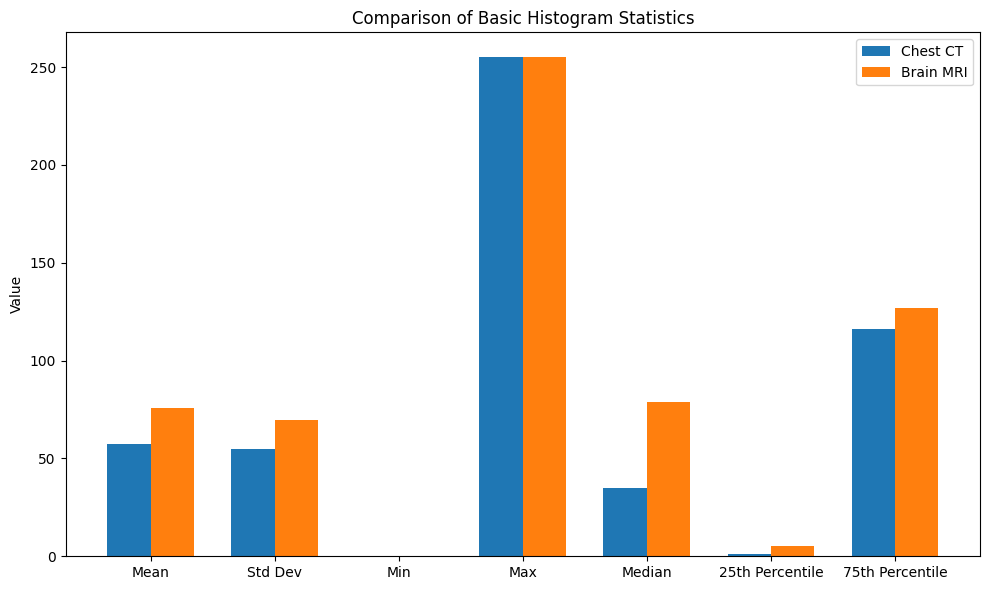

In [44]:
# Display a final summary comparing basic histogram statistics
stats = {
    'Mean': [np.mean(chest_ct), np.mean(brain_mri)],
    'Std Dev': [np.std(chest_ct), np.std(brain_mri)],
    'Min': [np.min(chest_ct), np.min(brain_mri)],
    'Max': [np.max(chest_ct), np.max(brain_mri)],
    'Median': [np.median(chest_ct), np.median(brain_mri)],
    '25th Percentile': [np.percentile(chest_ct, 25), np.percentile(brain_mri, 25)],
    '75th Percentile': [np.percentile(chest_ct, 75), np.percentile(brain_mri, 75)]
}

fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(stats))
width = 0.35

ax.bar(x - width/2, [stats[k][0] for k in stats], width, label='Chest CT')
ax.bar(x + width/2, [stats[k][1] for k in stats], width, label='Brain MRI')

ax.set_xticks(x)
ax.set_xticklabels(list(stats.keys()))
ax.set_ylabel('Value')
ax.set_title('Comparison of Basic Histogram Statistics')
ax.legend()

plt.tight_layout()
plt.show()

Thank you for exploring medical image histogram analysis with us. We hope this notebook provides a solid foundation for applying these techniques to your own medical imaging projects.

## 10. (Bonus) Advanced Applications in Medical Image Analysis

Building on histogram analysis, more sophisticated techniques can be applied:

1. Radiomics: Extracting hundreds of quantitative features (many histogram-based) from medical images to characterize disease
2. Content-Based Image Retrieval for Clinical Decision Support: Finding similar cases in large medical databases to aid diagnosis
3. Anomaly Detection: Using histogram features to identify regions that deviate from normal tissue patterns
4. Classification and Segmentation: Using histogram and texture features as inputs to machine learning algorithms for automated analysis
